In [18]:
import torch
from datasets import load_dataset
from transformers import ViTForImageClassification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor
import numpy as np
from PIL import Image

In [19]:


_checkpoint = '/Users/julio/Documents/PMM/Codigos/Test1/Classification-ViT/SavedModels/ViT-large-patch16-224_B/checkpoint-7520' 
# Crear pipeline de extracción de features usando el modelo ViT

_dataset = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/images_3categories_balanced'

dataset = load_dataset(_dataset)

processor = AutoImageProcessor.from_pretrained(_checkpoint, use_fast=True)
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels'] = batch['label']  # Las clases ya están en formato numérico
    return inputs
processed_dataset = dataset.with_transform(transforms)

# Cargar el modelo preentrenado
model = ViTForImageClassification.from_pretrained(_checkpoint)

# Eliminar la capa de clasificación para obtener solo las representaciones latentes
vit_without_classifier = torch.nn.Sequential(*list(model.children())[:-1])

device = torch.device("mps")
vit_without_classifier = vit_without_classifier.to(device)


Resolving data files:   0%|          | 0/7504 [00:00<?, ?it/s]

In [20]:
from torch.utils.data import DataLoader

# Crear DataLoader a partir del dataset procesado
dataloader = DataLoader(processed_dataset['train'], batch_size=8)  # Ajusta el batch_size según tu memoria

In [21]:
import torch
import numpy as np
from tqdm import tqdm  # Barra de progreso para visualizar el procesamiento

def extract_latent_features(dataloader, vit_without_classifier, device):
    """Extrae las representaciones latentes utilizando MPS o CPU."""
    vit_without_classifier.eval()  # Modo evaluación
    latent_features = []
    labels = []

    # Iterar sobre los batches en el DataLoader
    for batch in tqdm(dataloader, desc="Extrayendo representaciones latentes"):
        # Mover los datos al dispositivo correcto
        inputs = batch['pixel_values'].to(device)  # Imagen en MPS o CPU
        batch_labels = batch['labels'].to(device)

        with torch.no_grad():
            # Extraer las representaciones latentes
            output = vit_without_classifier(inputs).last_hidden_state
            latent_repr = output.mean(dim=1)  # Promediar sobre la secuencia
            latent_features.append(latent_repr.cpu().numpy())  # Mover a CPU para evitar saturación
            labels.extend(batch_labels.cpu().numpy())  # Guardar etiquetas en CPU

    # Convertir listas a arrays NumPy
    latent_features = np.vstack(latent_features)
    labels = np.array(labels)

    return latent_features, labels

# Ejecutar la extracción de características
latent_features, labels = extract_latent_features(dataloader, vit_without_classifier, device)

Extrayendo representaciones latentes: 100%|██████████| 938/938 [05:37<00:00,  2.78it/s]


In [22]:
from sklearn.decomposition import PCA

def apply_pca(latent_features, n_components=2):
    """Aplica PCA sobre las características latentes."""
    pca = PCA(n_components=n_components)
    latent_2d = pca.fit_transform(latent_features)
    print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
    return latent_2d

# Reducir las características latentes a 2 dimensiones
latent_2d = apply_pca(latent_features, n_components=2)

Varianza explicada por cada componente: [0.36526787 0.11048561]


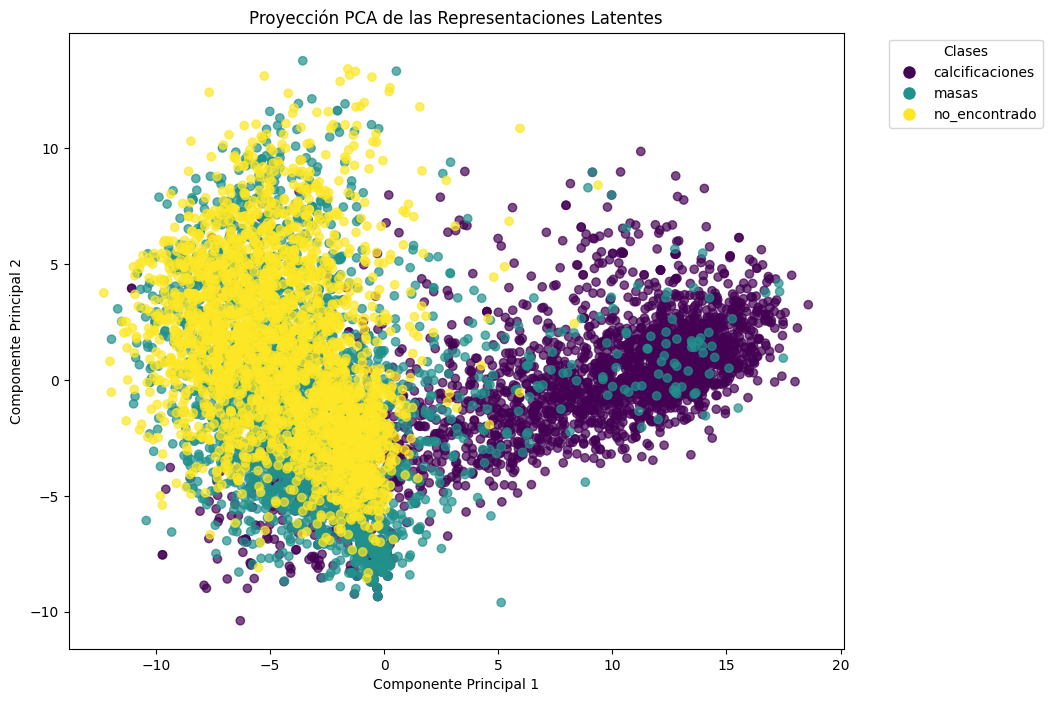

In [23]:
import matplotlib.pyplot as plt

def plot_pca(latent_2d, labels):
    """Grafica las características latentes proyectadas con PCA."""
    plt.figure(figsize=(10, 8))
    
    # Asumimos que tienes 3 categorías (ajusta los colores según sea necesario)
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    # Crear una leyenda manualmente
    # Para esto, creamos una lista de puntos con sus respectivos colores y nombres de clases
    class_names = dataset['train'].features['label'].names
    handles = []
    for i, class_name in enumerate(class_names):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                                  markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10))

    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title('Proyección PCA de las Representaciones Latentes')
    # Añadir la leyenda
    plt.legend(handles=handles, title="Clases", bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.colorbar(scatter, label='Etiqueta de la clase')
    plt.show()

# Visualizar las proyecciones PCA
plot_pca(latent_2d, labels)

Varianza explicada por las primeras 10 componentes:
[0.36526757 0.11048572 0.086895   0.05644941 0.03883136 0.03360173
 0.02238135 0.01652457 0.01484408 0.01038704]


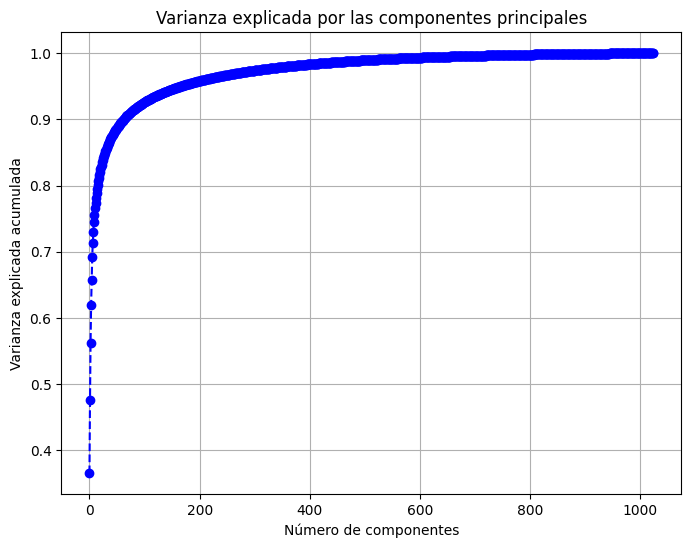

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Aplicar PCA considerando todas las componentes
pca = PCA()  # Si no especificas n_components, calculará todas las componentes
pca_result = pca.fit_transform(latent_features)

# Obtener la proporción de varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Imprimir la varianza explicada por las primeras componentes
print("Varianza explicada por las primeras 10 componentes:")
print(explained_variance[:10])

# Graficar la varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada por las componentes principales')
plt.grid(True)
plt.show()

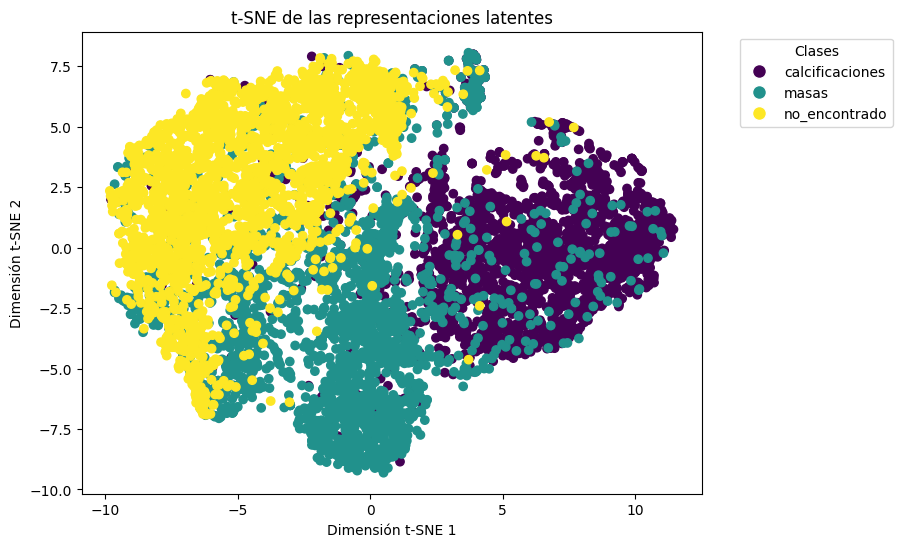

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE a las representaciones latentes (por ejemplo, el espacio después del encoder)
tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
tsne_result = tsne.fit_transform(latent_features)  # Asume que 'latent_representations' es el espacio latente

# Crear el gráfico t-SNE
plt.figure(figsize=(8, 6))

# Colores personalizados para cada clase
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
class_names = dataset['train'].features['label'].names
# Crear una leyenda manualmente
handles = []
for i, class_name in enumerate(class_names):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                              markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10))

# Añadir la leyenda
plt.legend(handles=handles, title="Clases", bbox_to_anchor=(1.05, 1), loc='upper left')

# Etiquetas y título
plt.xlabel('Dimensión t-SNE 1')
plt.ylabel('Dimensión t-SNE 2')
plt.title('t-SNE de las representaciones latentes')

# Mostrar gráfico
plt.show()